# Applied Data Science 1
### Dr. William Cooper
# Fitting

Fitting is a method of understanding types of relational data.
This can be 1D, 2D, 3D or more, either with, or without, measurement errors.
Simple data can be viewed by eye, e.g. drawing a line through same datapoints.
What about more complex data? Or we want to be able to quantify a fit?

## Goodness of Fit (GOF)
Fit functions have parameters to fit, for example, a straight line:
$$ f(x) = ax + b$$
has the two parameters $a$ and $b$.

The most widely used measure is $\chi^2$. 
It measures the quadratic deviation from the mean.
For a data set $(x_i, y_i)$ and a fit function $f(x)$ it is calculated

$$\chi^2 = \sum_{i=1}^N \left(\frac{y_i - f(x_i)}{\sigma_i}\right)^2$$

$\sigma_i$ represents the uncertainty of observation $y_i$.
Sometimes it is known, e.g. measurement errors in labs, but often it is not.
If $y_i$ represents counts, the uncertainty will be described by the Poisson statistics.
The variance is equal to the expected value and we can set $\sigma_i^2 = y_i$ and

$$\chi^2 = \sum_{i=1}^N \frac{(y_i - f(x_i))^2}{y_i}$$

$\chi^2$ has the probability distribution.

$$P(\chi^2) = (\chi^2)^{(\nu -2)/2} \exp\left(-\frac{\chi^2}{2}\right)$$

$\nu$ is the number of *degrees of freedom* of a model. It is $\nu = N-p$ with $p$ being the number of parameters. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss

- The probability is highest for $\chi^2 \approx \nu$. Thus sometimes the reduced $\chi^2_r$ which is $\frac{\chi^2}{\nu}$ is given. A good fit should have a value of $\approx 1$.
- A big danger is overfitting. Adding more parameters *always* reduces $\chi^2$, but that can be meaningless.
- Formal criteria to assess whether an improvment is meaningful can be derived using the AIC (Akaika information criterion) or BIC (Bayes information criterion).
- Rule of thumb: if the reduced $\chi^2_r$ has a value of about 1 it is time to stop. Optical inspection also important.
- The maximum number of parameters which can be fitted to $N$ datapoints is $p=N-1$. *Not* that this would be a meaningful fit.

Properties of the $\chi^2$ distribution:

$$\overline{\chi^2} = \nu$$
$$\text{Var}(\chi^2) = 2\nu$$

Thus for a good model we would expect:
$$\chi^2 = \nu \pm \sqrt{2\nu}$$

In [2]:
def plot_chi2():
    """
    Plots the chi2 and reduced chi2 distribution
    """
    fig, axs = plt.subplots(2, 2, dpi=144)
    axs = axs.flatten()
    
    for i in range(2, 10, 2):
        x_chi2 = np.linspace(ss.chi2.ppf(0.01, i), ss.chi2.ppf(0.99, i), 1000)
        y_chi2 = ss.chi2.pdf(x_chi2, i)
        y_chi2r = ss.chi2.pdf(x_chi2, i) / i
        y_chi2_cdf = ss.chi2.cdf(x_chi2, i)
        y_chi2_cdfr = y_chi2_cdf
        axs[0].plot(x_chi2, y_chi2, label=str(i))
        axs[1].plot(x_chi2 / i, y_chi2r, label=str(i))
        axs[2].plot(x_chi2, y_chi2_cdf, label=str(i))
        axs[3].plot(x_chi2 / i, y_chi2_cdfr, label=str(i))
    
    for ax in axs:
        ax.legend(title=r'$\nu$')
        if ax in axs[::2]:
            ax.set_xlabel('$\chi^2$')
        else:
            ax.set_xlabel('$\chi^2_{r}$')
        if ax in axs[:2]:
            ax.set_ylabel('PDF')
        else:
            ax.set_ylabel('CDF')
    
    fig.subplots_adjust(wspace=0.4, hspace=0.3)
    plt.show()
    return

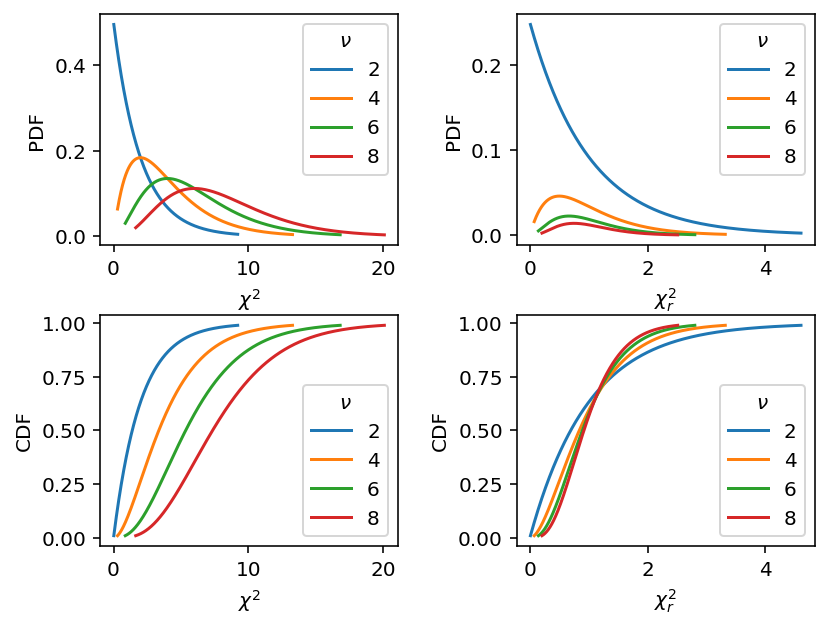

In [3]:
plot_chi2()

### Least square fitting

Building on the idea of $\chi^2$ as a measure of *goodness of fit* are methods of least square minimisation.

- given a data set of $N$ points $(x_i, y_i)$
- fit a function $f(x, \beta)$. $\beta$ is the vector of free parameters.
- Find the set of $\beta$ which minimises

$$\chi^2 = \sum_{i=1}^N \left(\frac{y_i - f(x_i)}{\sigma_i}\right)^2$$

or if we do not have estimates of $\sigma_i$,

$$\chi^2 = \sum_{i=1}^N (y_i - f(x_i))^2$$

- Least square fitting can rarely done by hand or simple graph paper work. 
- Note that the standard formula for fitting a straight line is derived from least square fitting.
- Fitting can be hard and CPU intensive, especially as a $\nu$ increases.

Two methods of fitting data in python (out of many options!):
scipy.optimize.curve_fit
numpy.polynomial.Polynomial

curve_fit uses a non-linear least squares solver, which by default is a wrapper around the Levenberg-Marquardt algorithm ("lm").
Without going too deep into the maths, this Levenberg-Marquardt algorithm cleverly swaps between gradient descent (good when far from minimum) and the Gauss-Newton algorithm (good close to the minimum).
Effectively, iteratively stepping around the data until it finds a minimum, i.e. minimising the residuals.

Polynomial uses a linear least squares solver, effectively just linear algebra. By this, we attempt to minimise the Euclidean distance between the model and the data.
You may encounter techniques like Singular Value Decomposition (SVD) which literally decomposes the matrix formed by the data, into components which can be solved by least squares algorithms.

In [4]:
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial as Poly

In [5]:
def plot_random_scatter_with_line(x, y, xline, yline):
    """
    Creates a scatter plot of random x and y data with overplotted line
    """
    plt.figure(dpi=144)

    # scatter plot
    plt.plot(x, y, 'bo')
    plt.plot(xline, yline, 'k-')
    
    # formatting
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    return

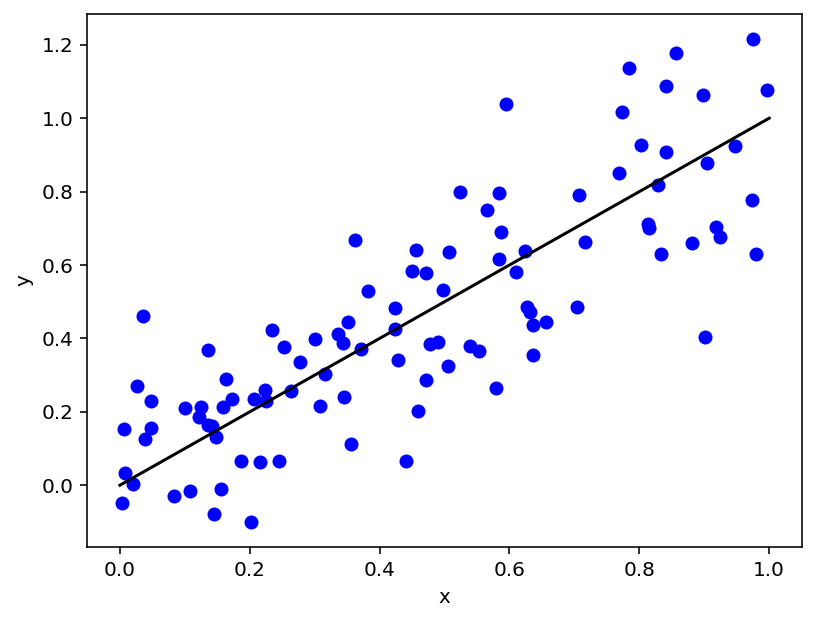

In [6]:
# creating random data from 0 to 1, remember this from the introduction week?
x = np.random.uniform(0, 1, 100)
# creating "noisy" data of the same size
y = x + np.random.normal(0, 0.2, len(x))

# line data
xline = np.linspace(0, 1, 10)
yline = xline
plot_random_scatter_with_line(x, y, xline, yline)

In [7]:
# now let's actually fit this data instead of just the assumed model
def linfunc(x, a, b):
    """ Function for fitting a straight line, for curve_fit
        x: independent variable
        a, b: parameters to be fitted
    """
    y = a*x + b
    return y

In [8]:
p, cov = curve_fit(linfunc, x, y)  # give it the function to be fitted then x and y

# the errors are the square root of the diagonal of the covariance matrix
sigma = np.sqrt(np.diag(cov))

print(f"a = {p[0]:.2f} +/- {sigma[0]:.2f}")
print(f"b = {p[1]:.2f} +/- {sigma[1]:.2f}")

a = 0.90 +/- 0.06
b = 0.05 +/- 0.03


In [9]:
p_np = Poly.fit(x, y, 1)  # Polynomial just needs x, y data and the number of degrees
cov = np.polyfit(x, y, 1, cov=True)[1]  # need a separate call as numpy devs have still not merged
sigma_np = np.sqrt(np.diag(cov))

b, a = p_np.convert().coef  # note the opposite order of coefficients
print(f"a = {a:.2f} +/- {sigma_np[0]:.2f}")
print(f"b = {b:.2f} +/- {sigma_np[1]:.2f}")

a = 0.90 +/- 0.06
b = 0.05 +/- 0.03


In [10]:
def plot_random_scatter_with_fitted_line(x, y, xline, yline):
    """
    Creates a scatter plot of random x and y data with overplotted line
    """
    plt.figure(dpi=144)

    # scatter plot
    plt.plot(x, y, 'bo')
    plt.plot(xline, yline, 'k--')

    # make some data for the fitted line, using scipy
    xfit = np.linspace(np.min(x), np.max(x), 100)
    plt.plot(xfit, linfunc(xfit, p[0], p[1]), 'k-')  # note the call to the defined function
    # see error margins as f(x) = ax + b
    plt.fill_between(xfit, linfunc(xfit, p[0] - sigma[0], p[1] - sigma[1]),
                     linfunc(xfit, p[0] + sigma[0], p[1] + sigma[1]), color='k', alpha=0.1)

    plt.plot(*p_np.linspace(), 'k-')
    
    # formatting
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    return

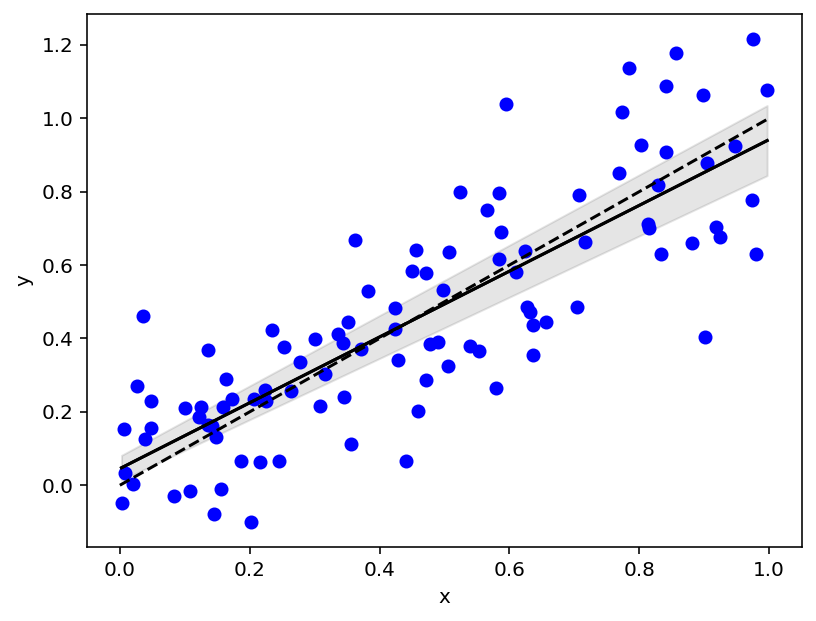

In [11]:
plot_random_scatter_with_fitted_line(x, y, xline, yline)

- Assuming only one parameter $p$ with uncertainty $\sigma_p$. The uncertainty of the fit result would be 
$$\frac{\delta f}{\delta p}\,\sigma_p$$
- For two or more parameters $p_1$, $p_2$ with uncertainties. If the parameters are independent, i.e. uncorrelated the uncertainty would be added in quadrature:
$$\sqrt{\left(\frac{\delta f}{\delta p_1}\,\sigma_{p1}\right)^2 
       + \left( \frac{\delta f}{\delta p_2}\,\sigma_{p2}\right)^2}$$
- Look at the full covariance matrix to understand if they are indeed independent.

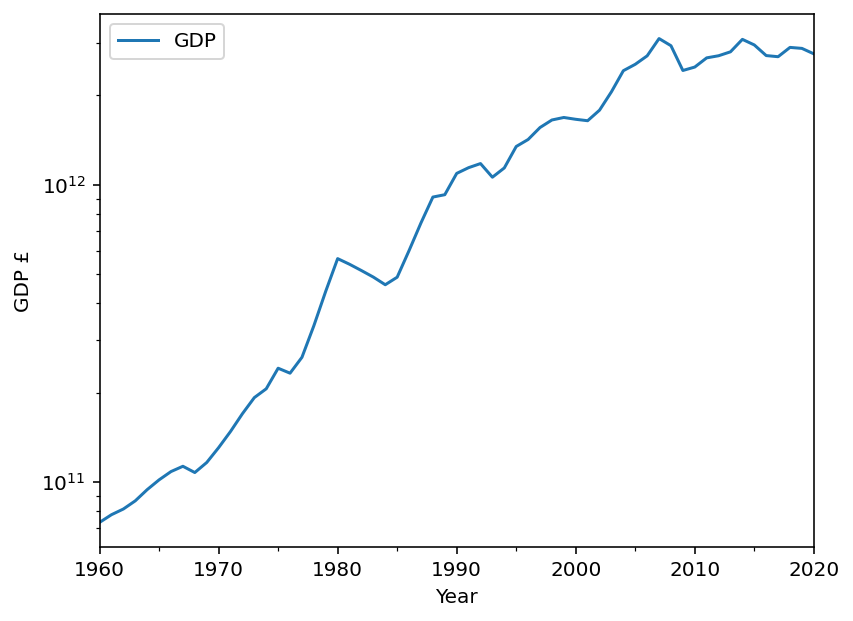

In [12]:
# Try some non-linear data, will focus just on scipy
df_gdp = pd.read_csv('Data/UK_GDP.csv', index_col='Year', parse_dates=['Year'])
fig, ax = plt.subplots(dpi=144)
df_gdp.plot(ax=ax, logy=True, ylabel='GDP £')
plt.show()

In [13]:
def exponential(t, n0, g):
    """
    Calculates exponential function with scale factor n0 and growth rate g.
    """
    
    f = n0 * np.exp(g*t)
    
    return f

In [14]:
# let's normalise the time frame, quite important for exponentials
numeric_index = (df_gdp.index.year - 1990).values
# give some initial guesses of N0 and growth
p, cov = curve_fit(exponential, numeric_index, df_gdp['GDP'],
                   p0=(1.2e12, 0.03))

# get uncertainties on each parameter
sigma = np.sqrt(np.diag(cov))

print(f"N0 = {p[0]:g} +/- {sigma[0]:g}")
print(f"g = {p[1]:.2f} +/- {sigma[1]:.2f}")

N0 = 1.00397e+12 +/- 5.55762e+10
g = 0.04 +/- 0.00


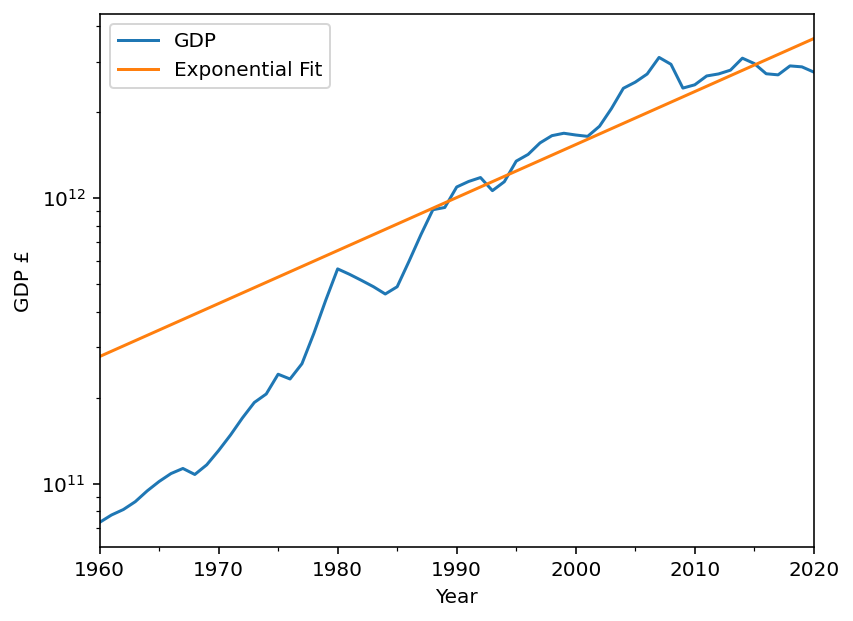

In [15]:
fig, ax = plt.subplots(dpi=144)
df_gdp['Exponential Fit'] = exponential(numeric_index, *p)
df_gdp.plot(y=['GDP', 'Exponential Fit'], logy=True, ax=ax, ylabel='GDP £')
plt.show()

In [16]:
def logistic(t, n0, g, t0):
    """
    Calculates the logistic function with scale factor n0 and growth rate g
    """
    
    f = n0 / (1 + np.exp(-g*(t - t0)))
    
    return f

Let's try with a logistic function, as that behaves like exponential distributions at low $t$, 
but asymptotes to $N$ as $|t| \rightarrow \infty$.
There is a 'turning point' at $N/2$.
$$L(t) = \frac{N}{1-\exp(-g(t-t_0))}$$

In [17]:
p, cov = curve_fit(logistic, numeric_index, df_gdp['GDP'],
                  p0=(1.2e12, 0.03, 10))

sigma = np.sqrt(np.diag(cov))

print(f"N0 = {p[0]:g} +/- {sigma[0]:g}")
print(f"g = {p[1]:.2f} +/- {sigma[1]:.2f}")
print(f"t0 = {p[2] + 1990:.2f} +/- {sigma[2]:.2f}")

N0 = 3.17425e+12 +/- 1.07288e+11
g = 0.12 +/- 0.01
t0 = 1996.86 +/- 0.85


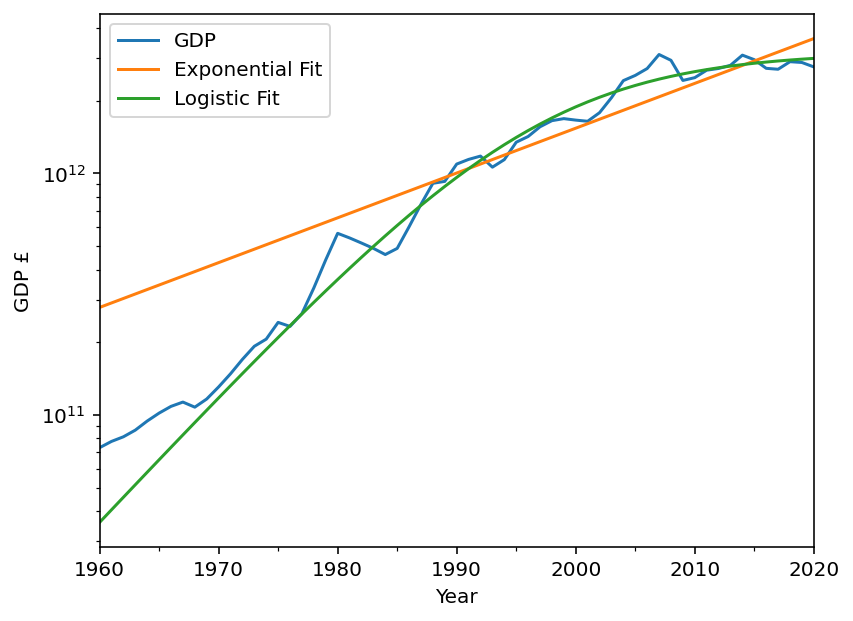

In [18]:
fig, ax = plt.subplots(dpi=144)
df_gdp['Logistic Fit'] = logistic(numeric_index, *p)
df_gdp.plot(ax=ax, ylabel='GDP £')
ax.set_yscale('log')
plt.show()

# Exercise 1
Determine a fit to the population in the `india_population.csv` file. You should start be plotting the population.

In [ ]:
df_pop = pd.read_csv()

In [ ]:
print()
print()

In [ ]:
plt.show()

## End Exercise 1
Extrapolating into the future is as simple as putting the desired dates into your function!

In [25]:
numeric_index = (df_gdp.index.year - 1990).values
p, cov = curve_fit(logistic, numeric_index, df_gdp['GDP'],
                  p0=(1.2e12, 0.03, 10))
gdp_2050 = logistic(2050 - 1990, *p)  # remember to subtract the 1990 as we did when 'training'
print(f"GDP in 2050: {gdp_2050:g}")

GDP in 2050: 3.16922e+12


However, the uncertainty on this prediction is not as simple and depends on the **distributions of the parameter uncertainties**.
Here, we will assume the simplest case, of a normal distribution:

In [27]:
# take 1000 normal random samples for each parameter
sample_params = ss.multivariate_normal.rvs(mean=p, cov=cov, size=1000)

# standard deviation of all possible parameter sampling
gdp_unc_2050 = np.std(logistic(2050 - 1990, *sample_params.T))  # note the transpose

print(f"GDP in 2050: {gdp_2050:g} +/- {gdp_unc_2050:g}")

GDP in 2050: 3.16922e+12 +/- 1.08164e+11


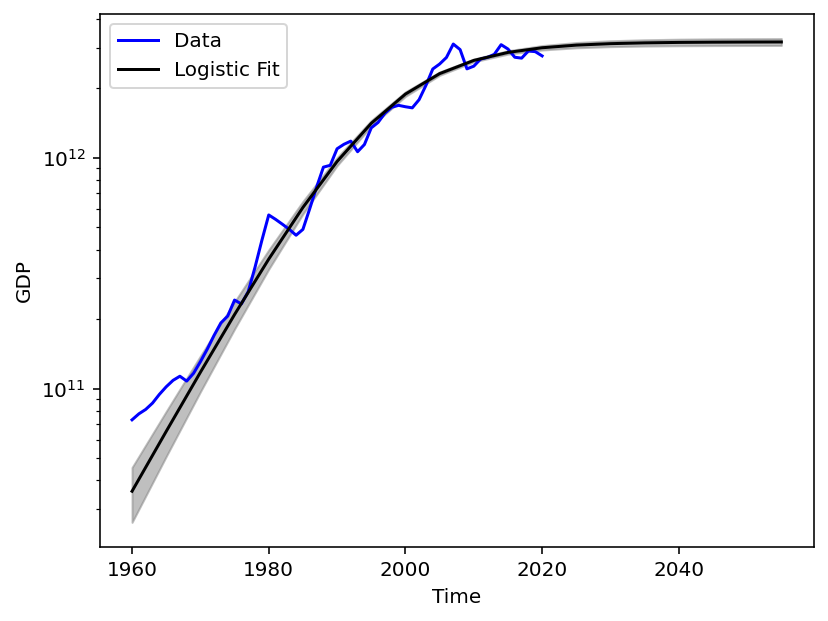

In [30]:
fig, ax = plt.subplots(dpi=144)
# create array of values within data, and beyond
time_predictions = np.arange(1960, 2060, 5)
# determine predictions for each of those times
gdp_predictions = logistic(time_predictions - 1990, *p)
# determine uncertainty at each prediction
gdp_uncertainties = [np.std(logistic(future_time - 1990, *sample_params.T)) for future_time in time_predictions]

ax.plot(df_gdp.index.year, df_gdp['GDP'], 'b-', label='Data')
ax.plot(time_predictions, gdp_predictions, 'k-', label='Logistic Fit')
ax.fill_between(time_predictions, gdp_predictions - gdp_uncertainties, gdp_predictions + gdp_uncertainties, 
                color='gray', alpha=0.5)
ax.set_xlabel('Time')
ax.set_ylabel('GDP')
ax.legend()
ax.set_yscale('log')
plt.show()

# Exercise 2
Using your best fitting model from exercise 1, create predictions for 2030 and show a plot of predictions up to 2060 for the `india_population.csv`.

In [ ]:
print()

In [ ]:
plt.show()

## End Exercise 2
Hopefully, you may have spotted some issues with extrapolating too far into the future.
Remember, extrapolation will only follow what the model is tending to mathematically.
A model has no idea of other possible effects on the dataset and is **only as good as the data it was fitted to**.